In [1]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [2]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

5

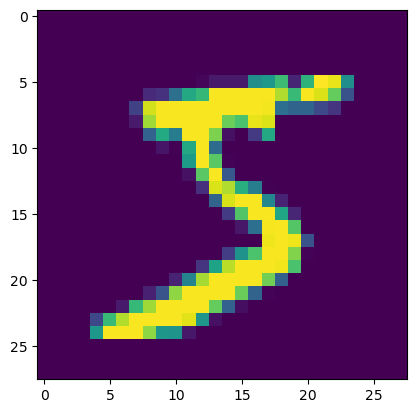

In [3]:
plt.imshow(x_train[0])
labels_train[0]

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 28, 28)

# Reshape the data to fit the model

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [6]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

# Define the CNN model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                         

2023-02-20 13:08:38.367447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 13:08:38.367564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# K-fold cross-validation

In [10]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

In [11]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

In [12]:
# Train and evaluate the model with k-fold cross-validation
from sklearn.metrics import precision_score, f1_score, recall_score
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


historys = []
accuracies = []
losses = []
precisions = []
f1_scores = []
recalls = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=512),
                        epochs=10,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5), LearningRateScheduler(scheduler)])
    
    historys.append(history)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Accuracy:', accuracy)
    print('Loss:', loss)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    accuracies.append(accuracy)
    losses.append(loss)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

print('Average accuracy:', np.mean(accuracies))
print('Average loss:', np.mean(losses))
print('Average precision:', np.mean(precisions))
print('Average recall:', np.mean(recalls))
print('Average F1-score:', np.mean(f1_scores))

Fold: 1
Epoch 1/10


2023-02-20 13:08:39.089947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 13:08:39.442032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/94 [============================>.] - ETA: 0s - loss: 0.8502 - accuracy: 0.7349

2023-02-20 13:08:45.065096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 9s 81ms/step - loss: 0.8448 - accuracy: 0.7365 - val_loss: 2.5315 - val_accuracy: 0.1196 - lr: 0.0010
Epoch 2/10
94/94 [==============================] - 7s 75ms/step - loss: 0.2503 - accuracy: 0.9246 - val_loss: 3.3066 - val_accuracy: 0.1167 - lr: 0.0010
Epoch 3/10
94/94 [==============================] - 7s 73ms/step - loss: 0.1693 - accuracy: 0.9489 - val_loss: 2.5100 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 4/10
94/94 [==============================] - 7s 74ms/step - loss: 0.1309 - accuracy: 0.9608 - val_loss: 0.7652 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 5/10
94/94 [==============================] - 7s 71ms/step - loss: 0.1129 - accuracy: 0.9658 - val_loss: 0.1522 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 6/10
94/94 [==============================] - 7s 71ms/step - loss: 0.0953 - accuracy: 0.9724 - val_loss: 0.0557 - val_accuracy: 0.9839 - lr: 1.0000e-04
Epoch 7/10
94/94 [==============================] - 7s 71ms/step - loss: 0.0895 - a

2023-02-20 13:09:49.922337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 30/313 [=>............................] - ETA: 1s

2023-02-20 13:09:52.993986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.9899000525474548
Loss: 0.030556349083781242
Precision: 0.9897834865105584
Recall: 0.9900164025184068
F1-score: 0.9898832496860004
Fold: 2
Epoch 1/10
94/94 [==============================] - 7s 73ms/step - loss: 0.0907 - accuracy: 0.9728 - val_loss: 0.0381 - val_accuracy: 0.9887 - lr: 1.0000e-08
Epoch 2/10
94/94 [==============================] - 7s 73ms/step - loss: 0.0903 - accuracy: 0.9735 - val_loss: 0.0383 - val_accuracy: 0.9888 - lr: 1.0000e-08
Epoch 3/10
94/94 [==============================] - 7s 74ms/step - loss: 0.0903 - accuracy: 0.9739 - val_loss: 0.0383 - val_accuracy: 0.9887 - lr: 1.0000e-08
Epoch 4/10
94/94 [==============================] - 7s 73ms/step - loss: 0.0908 - accuracy: 0.9731 - val_loss: 0.0384 - val_accuracy: 0.9887 - lr: 1.0000e-08
Epoch 5/10
94/94 [==============================] - 7s 74ms/step - loss: 0.0860 - accuracy: 0.9747 - val_loss: 0.0384 - val_accuracy: 0.9887 - lr: 1.0000e-08
Epoch

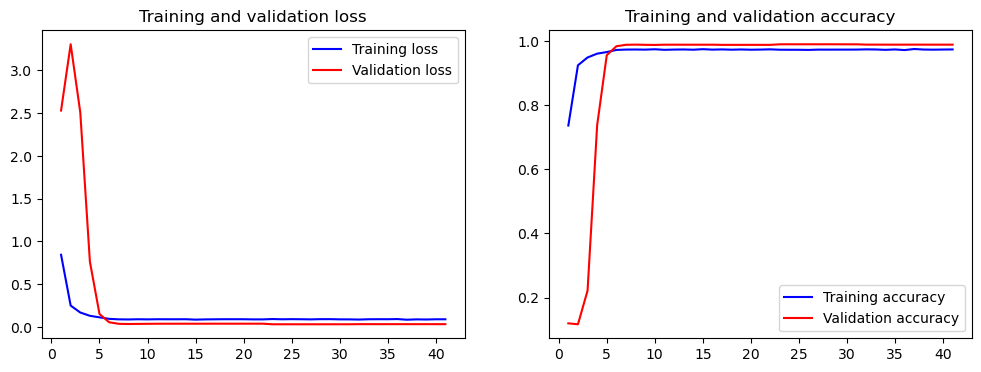

In [13]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [14]:
model.save("network_for_mnist.h5")